# 2.0.0: Model performance


Let's take a look at how our different models perform. There are quite a few models to compare, so there are a few ways we can visualize and assess performance.

For instance, we trained models for each of 33 traits for 3 "trait sets" (i.e. the provenance of the gridded trait data: sPlot-only, GBIF-only, and sPlot + GBIF combined). Below we will explore both general, trait set-level trends as well as zoom in on 8 traits specifically to assess trait-level trends.


## Imports and config


In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import font_manager

from src.conf.conf import get_config
from src.conf.environment import log
from src.utils.dataset_utils import get_latest_run, get_models_dir
from src.utils.trait_utils import get_trait_name_from_id
from src.visualization.model_assessment import plot_splot_correlations

cfg = get_config()


font_path = "/usr/share/fonts/opentype/freefont/FreeSans.otf"
font_bold_path = "/usr/share/fonts/opentype/freefont/FreeSansBold.otf"
font_manager.fontManager.addfont(font_path)
font_manager.fontManager.addfont(font_bold_path)
plt.rcParams["font.family"] = "FreeSans"

## Model performance across all traits and trait sets at 1 km resolution.


Load combined results across all runs.


In [2]:
all_results = pd.read_parquet("results/all_results.parquet")
# Replace each trait_id with its corresponding trait name using a dictionary
trait_id_to_name = {
    trait_id: get_trait_name_from_id(trait_id)[0]
    for trait_id in all_results.trait_id.unique()
}

trait_set_to_ID = {"splot": "SCI", "splot_gbif": "COMB", "gbif": "CIT"}
all_results["trait_name"] = all_results.trait_id.map(trait_id_to_name)
all_results["trait_set_id"] = all_results.trait_set.map(trait_set_to_ID)
all_results.head()

pft resolution   trait_id   trait_set  automl model_arch  \
0  Shrub_Tree_Grass        001  X163_mean       splot    True        GBM   
1  Shrub_Tree_Grass        001  X163_mean       splot    True        GBM   
2  Shrub_Tree_Grass        001  X163_mean        gbif    True        GBM   
3  Shrub_Tree_Grass        001  X163_mean        gbif    True        GBM   
4  Shrub_Tree_Grass        001  X163_mean  splot_gbif    True        GBM   

            run_id        r2  pearsonr  pearsonr_wt  root_mean_squared_error  \
0  20240827_032644  0.168091  0.414057     0.440022                 0.367905   
1  20240827_032644  0.233690  0.503460     0.525381                 0.188455   
2  20240827_032644 -0.082184  0.288847     0.308069                 0.419613   
3  20240827_032644 -0.216775  0.360967     0.375796                 0.242961   
4  20240827_032644  0.135023  0.393680     0.418676                 0.375146   

   norm_root_mean_squared_error  mean_squared_error  mean_absolute_error  \
0                      0.211601            0.135354             0.204053   
1                      0.193087            0.035515             0.134164   
2                      0.241340            0.176075             0.290659   
3                      0.243514            0.059030             0.196692   
4                      0.215765            0.140734             0.224991   

   median_absolute_error transform       trait_name trait_set_id  
0               0.141102      none  Leaf fresh mass          SCI  
1               0.103798       log  Leaf fresh mass          SCI  
2               0.239805      none  Leaf fresh mass          CIT  
3               0.175843       log  Leaf fresh mass          CIT  
4               0.168629      none  Leaf fresh mass         COMB

Let's select only the 1 km runs.


In [4]:
res_1km = all_results.query("resolution == '1km' and transform == 'power'")
res_1km.head()

pft resolution    trait_id   trait_set  automl model_arch  \
991  Shrub_Tree_Grass        1km   X138_mean  splot_gbif    True        GBM   
993  Shrub_Tree_Grass        1km   X138_mean        gbif    True        GBM   
995  Shrub_Tree_Grass        1km  X3112_mean       splot    True        GBM   
997  Shrub_Tree_Grass        1km  X3112_mean  splot_gbif    True        GBM   
999  Shrub_Tree_Grass        1km  X3112_mean        gbif    True        GBM   

              run_id        r2  pearsonr  pearsonr_wt  \
991  20241122_230826  0.185268  0.433921          NaN   
993  20241122_230826  0.036955  0.201485          NaN   
995  20241130_131639  0.262695  0.515789          NaN   
997  20241130_131639  0.274120  0.534099          NaN   
999  20241130_131639  0.198258  0.520787          NaN   

     root_mean_squared_error  norm_root_mean_squared_error  \
991                 0.651550                      0.174187   
993                 0.708376                      0.189378   
995                 0.584745                      0.194613   
997                 0.580197                      0.193100   
999                 0.609762                      0.202939   

     mean_squared_error  mean_absolute_error  median_absolute_error transform  \
991            0.424518             0.499099               0.398027     power   
993            0.501796             0.535707               0.419592     power   
995            0.341926             0.459922               0.381316     power   
997            0.336628             0.460274               0.387335     power   
999            0.371809             0.493467               0.431416     power   

              trait_name trait_set_id  
991  Seed number (repr.)         COMB  
993  Seed number (repr.)          CIT  
995     Leaf area (3112)          SCI  
997     Leaf area (3112)         COMB  
999     Leaf area (3112)          CIT

Increase in Pearson's $r$ between SCI/COMB and CIT

In [5]:
splot_1km = res_1km.query("trait_set == 'splot'")
splot_gbif_1km = res_1km.query("trait_set == 'splot_gbif'")
gbif_1km = res_1km.query("trait_set == 'gbif'")

mean_splot_r = splot_1km.pearsonr.mean()
mean_splot_gbif_r = splot_gbif_1km.pearsonr.mean()
mean_gbif_r = gbif_1km.pearsonr.mean()

print(
    f"SCI/COMB models show an increase in $r$ by {((mean_splot_gbif_r + mean_splot_r) / 2) - mean_gbif_r}"
)

SCI/COMB models show an increase in $r$ by 0.11829108776160513


In [7]:
print(f"{len(splot_1km.query('pearsonr >= 0.5'))} models with r >= 0.5")
print(f"{len(splot_gbif_1km.query('pearsonr >= 0.5'))} models with r >= 0.5")
print(f"{len(gbif_1km.query('pearsonr >= 0.5'))} models with r >= 0.5")

18 models with r >= 0.5
17 models with r >= 0.5
8 models with r >= 0.5


Top performing traits for SCI, COMB, and CIT

In [9]:
print(
    f"Top 6 traits for sPlot: {splot_1km.sort_values('pearsonr', ascending=False).trait_name.unique()[:6]}"
)
print(
    f"Top 6 traits for sPlot+GBIF: {splot_gbif_1km.sort_values('pearsonr', ascending=False).trait_name.unique()[:6]}"
)
print(
    f"Top 6 traits for GBIF: {gbif_1km.sort_values('pearsonr', ascending=False).trait_name.unique()[:6]}"
)

Top 6 traits for sPlot: ['Leaf N (area)' 'SLA' 'RRD' 'SSD' 'Stem conduit diameter'
 'Leaf area (3113)']
Top 6 traits for sPlot+GBIF: ['Leaf N (area)' 'SLA' 'Stem conduit diameter' 'RRD' 'Leaf area (3113)'
 'SSD']
Top 6 traits for GBIF: ['Leaf N (area)' 'Leaf area (3114)' 'Leaf area (3113)' 'SLA'
 'Stem conduit diameter' 'Leaf area (3112)']


Plot rudimentary bar graphs to visualize performance metrics.

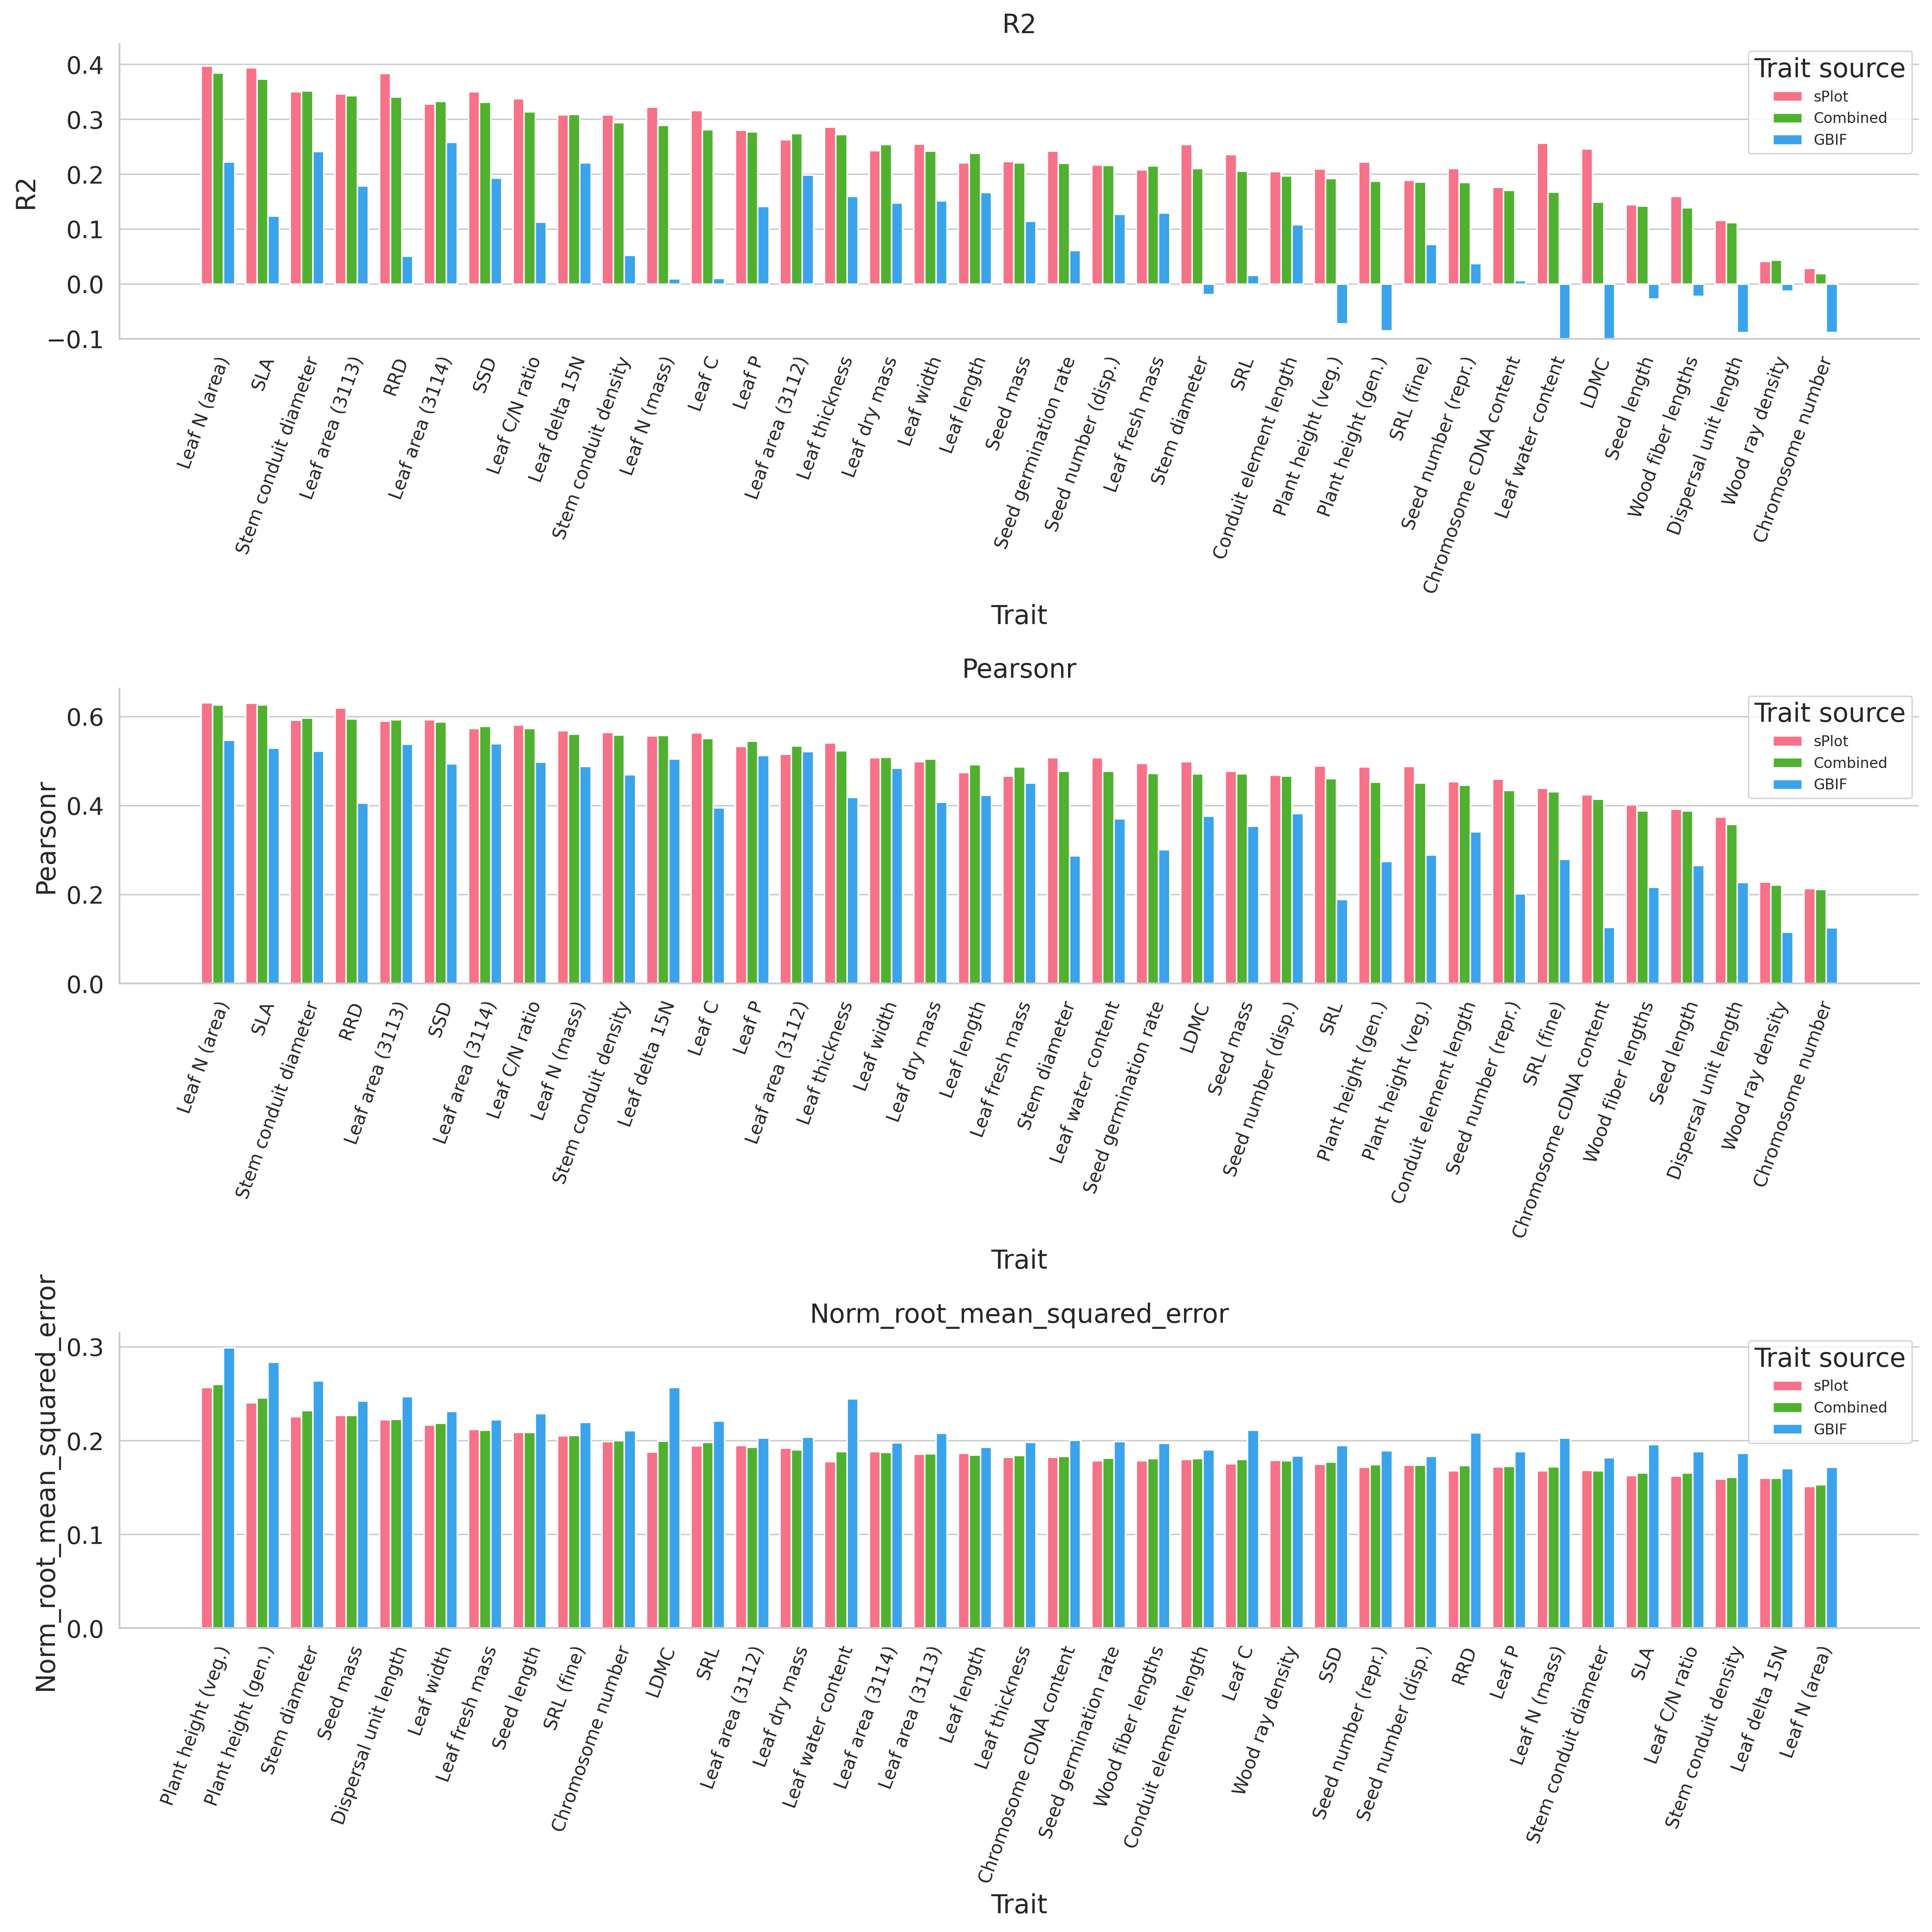

In [6]:
# Prepare data
treatments = ["splot", "splot_gbif", "gbif"]
metrics = ["r2", "pearsonr", "norm_root_mean_squared_error"]

# Set the color palette for treatments
colors = sns.color_palette("husl", len(treatments))
color_dict = dict(zip(treatments, colors))

with sns.plotting_context("paper", font_scale=1.5), sns.axes_style("whitegrid"):
    nrows = 3
    ncols = 1
    # Create subplots for each metric
    fig, axs = plt.subplots(
        nrows=nrows, ncols=ncols, figsize=(15 * ncols, 5 * nrows), dpi=300
    )
    axs = axs.flatten()

    for i, metric in enumerate(metrics):
        # Get traits in the order of the metric
        traits = (
            res_1km.query("trait_set == 'splot_gbif' and transform == 'power'")
            .sort_values(by=metric, ascending=False)
            .trait_id.unique()
        )
        axes = axs[i]

        # Prepare data for the current metric
        data = []
        for trait_id in traits:
            trait_name = get_trait_name_from_id(trait_id)[0]

            for treatment in treatments:
                mean_value = res_1km.query(
                    f"trait_id == '{trait_id}' and trait_set == '{treatment}' and transform == 'power'"
                )[metric].values[0]
                std_value = np.nan

                data.append([trait_name, treatment, mean_value, std_value])

        df = pd.DataFrame(
            data, columns=["trait_name", "treatment", "mean_value", "std_value"]
        )

        # Create bar plot with error bars
        bar_width = 0.3  # Bar width
        gap = 0.3  # Gap between groups of bars
        x = np.arange(len(traits)) * (len(treatments) * bar_width + gap)

        error_kw = {
            "elinewidth": 1,  # Error bar thickness
            "ecolor": "grey",  # Error bar color
            "capsize": 2,  # Cap size for error bars
        }

        def map_treatment(treatment: str) -> str:
            if treatment == "splot":
                return "sPlot"
            if treatment == "splot_gbif":
                return "Combined"
            if treatment == "gbif":
                return "GBIF"
            else:
                raise ValueError(f"Unknown treatment {treatment}")

        for i, treatment in enumerate(treatments):
            subset = df[df["treatment"] == treatment]
            axes.bar(
                x + i * bar_width,
                subset["mean_value"],
                yerr=subset["std_value"],
                width=bar_width,
                label=map_treatment(treatment),
                color=color_dict[treatment],
                error_kw=error_kw,
            )

        axes.set_title(f"{metric.capitalize()}")
        axes.set_xlabel("Trait")
        axes.set_ylabel(metric.capitalize())
        axes.set_xticks(
            (x + bar_width * (len(treatments) - 1) / 2) - 0.05,
            [get_trait_name_from_id(t)[0] for t in traits],
            rotation=70,
            ha="right",
            va="top",
            rotation_mode="anchor",
            fontsize=10,
        )
        # ax.set_xticklabels([get_trait_name_from_id(t)[0] for t in traits], rotation=90)
        axes.legend(title="Trait source", fontsize=8)

        # Set y-axis limits for R²
        if metric == "r2":
            axes.set_ylim(-0.1)

        sns.despine()
        axes.grid(False, axis="x")

    plt.tight_layout()
    plt.show()

### Scatterplots of observed vs predicted


In [ ]:
trait_ids = res_1km.trait_id.unique()
trait_set_ids = res_1km.trait_set.unique()

In [ ]:
import scipy


def plot_observed_vs_predicted(
    ax: plt.Axes,
    observed: pd.Series,
    predicted: pd.Series,
    name: str,
    name_color: str = "black",
    log: bool = False,
    density: bool = False,
    stats: dict = {},
    show_x_label: bool = True,
    show_y_label: bool = True,
):
    """Plot observed vs. predicted values."""

    # plot the observed vs. predicted values using seaborn
    # sns.set_theme()

    p1 = min(predicted.min(), observed.min())
    p2 = max(predicted.max(), observed.max())

    cmap = sns.cubehelix_palette(start=0.5, rot=-0.75, reverse=True, as_cmap=True)  # type: ignore
    if density:
        sns.kdeplot(
            x=predicted, y=observed, ax=ax, cmap=cmap, fill=False, thresh=0.0075
        )
    else:
        sns.scatterplot(x=predicted, y=observed, ax=ax, s=1, alpha=0.01, edgecolor=None)

    # Fit a regression line for observed vs. predicted values, plot the regression
    # line so that it spans the entire plot, and print the correlation coefficient
    # Get m and b using scipy.stats.lingress

    m, b = scipy.stats.linregress(predicted, observed)[:2]
    reg_line = [m * p1 + b, m * p2 + b]

    if log:
        ax.loglog([p1, p2], [p1, p2], color="black", ls="-.", lw=0.5, alpha=0.5)
        ax.loglog([p1, p2], reg_line, color="red", lw=0.5)
    else:
        ax.plot([p1, p2], [p1, p2], color="black", ls="-.", lw=0.5, alpha=0.5)
        ax.plot([p1, p2], reg_line, color="red", lw=0.5)

    # make sure lines are positioned on top of kdeplot
    ax.set_zorder(1)

    if stats:
        for i, (key, value) in enumerate(stats.items()):
            ax.text(
                0.05,
                0.95 - i * 0.1,
                f"{key} = {value:.3f}",
                transform=ax.transAxes,
                ha="left",
                va="top",
            )

    # include legend items for the reg_line and the 1-to-1 line
    ax.legend(
        [
            ax.get_lines()[0],
            ax.get_lines()[1],
        ],
        ["1-to-1", "Regression"],
        loc="lower right",
        frameon=False,
    )

    # set informative axes and title
    if show_x_label:
        ax.set_xlabel("Predicted")
    else:
        ax.set_xlabel("")
    if show_y_label:
        ax.set_ylabel("Observed")
    else:
        ax.set_ylabel("")
    ax.set_title(name, color=name_color)

    return ax

In [ ]:
import warnings

import matplotlib.gridspec as gridspec

warnings.filterwarnings("ignore")

traits = [d for d in Path("results/Shrub_Tree_Grass/001").glob("*") if d.is_dir()]
ts = ["splot", "splot_gbif", "gbif"]
m = len(traits)
n = len(ts)
# Create the main GridSpec
fig = plt.figure(figsize=(n * 6, m * 4), dpi=200)
outer_grid = gridspec.GridSpec(m, n, wspace=0.2, hspace=0.7)

trait_set_cmap = {"splot": "red", "splot_gbif": "green", "gbif": "blue"}

trait_set_names = {"splot": "sPlot", "splot_gbif": "Combined", "gbif": "GBIF"}

with sns.plotting_context("paper", font_scale=1), sns.axes_style("ticks"):
    for i, trait_dir in enumerate(traits):
        trait_id = trait_dir.name
        for j, trait_set_id in enumerate(ts):
            # Create a nested GridSpec for each cell in the main grid
            inner_grid = gridspec.GridSpecFromSubplotSpec(
                1, 2, subplot_spec=outer_grid[i, j], hspace=0.1
            )

            results_dir = get_latest_run(trait_dir / trait_set_id)

            desired_stats = ["r2", "pearsonr", "norm_root_mean_squared_error"]
            col_map = {
                "r2": "R²",
                "pearsonr": "$r$",
                "norm_root_mean_squared_error": "nRMSE",
            }

            stats = (
                res_1km.query(
                    f"trait_id == '{trait_id}' and trait_set == '{trait_set_id}' and transform == 'none'"
                )[desired_stats]
                .rename(columns=col_map)
                .to_dict(orient="records")[0]
            )
            stats_ln = (
                res_1km.query(
                    f"trait_id == '{trait_id}' and trait_set == '{trait_set_id}' and transform == 'log'"
                )[desired_stats]
                .rename(columns=col_map)
                .to_dict(orient="records")[0]
            )

            obs_vs_pred = pd.read_parquet(
                results_dir / "cv_obs_vs_pred.parquet"
            ).sample(frac=0.1)

            scale = min(obs_vs_pred["obs"].min(), obs_vs_pred["pred"].min())
            obs_vs_pred_ln = np.log1p(obs_vs_pred[["obs", "pred"]] + abs(scale))

            # Create the first subsubplot
            ax1 = plt.Subplot(fig, inner_grid[0])
            fig.add_subplot(ax1)

            plot_observed_vs_predicted(
                ax1,
                obs_vs_pred["obs"],
                obs_vs_pred["pred"],
                f"{trait_set_names[trait_set_id]}",
                name_color=trait_set_cmap[trait_set_id],
                log=False,
                density=False,
                stats=stats,
                show_y_label=True,
            )

            # Create the second subsubplot
            ax2 = plt.Subplot(fig, inner_grid[1])
            fig.add_subplot(ax2)

            plot_observed_vs_predicted(
                ax2,
                obs_vs_pred_ln["obs"],
                obs_vs_pred_ln["pred"],
                f"{trait_set_names[trait_set_id]} (log)",
                name_color=trait_set_cmap[trait_set_id],
                log=True,
                density=False,
                stats=stats_ln,
                show_y_label=False,
            )

            # For each row in the outer_grid, set a title corresponding to the trait name.
            # The title should be centered above the subplots in the row. The title should
            # not be tied to a specific axis.
            if j == 1:
                ax1.annotate(
                    get_trait_name_from_id(trait_id)[0],
                    xy=(0.5, 1.2),
                    xytext=(0, 5),
                    textcoords="offset points",
                    ha="center",
                    va="baseline",
                    fontsize=12,
                    color="black",
                    weight="bold",
                    xycoords="axes fraction",
                )

    sns.despine()
    plt.show()

ValueError: Number of rows must be a positive integer, not 0

<Figure size 3600x0 with 0 Axes>

### Violin plots aggregating all traits for each trait set


Compare log-transformed and untransformed metrics.


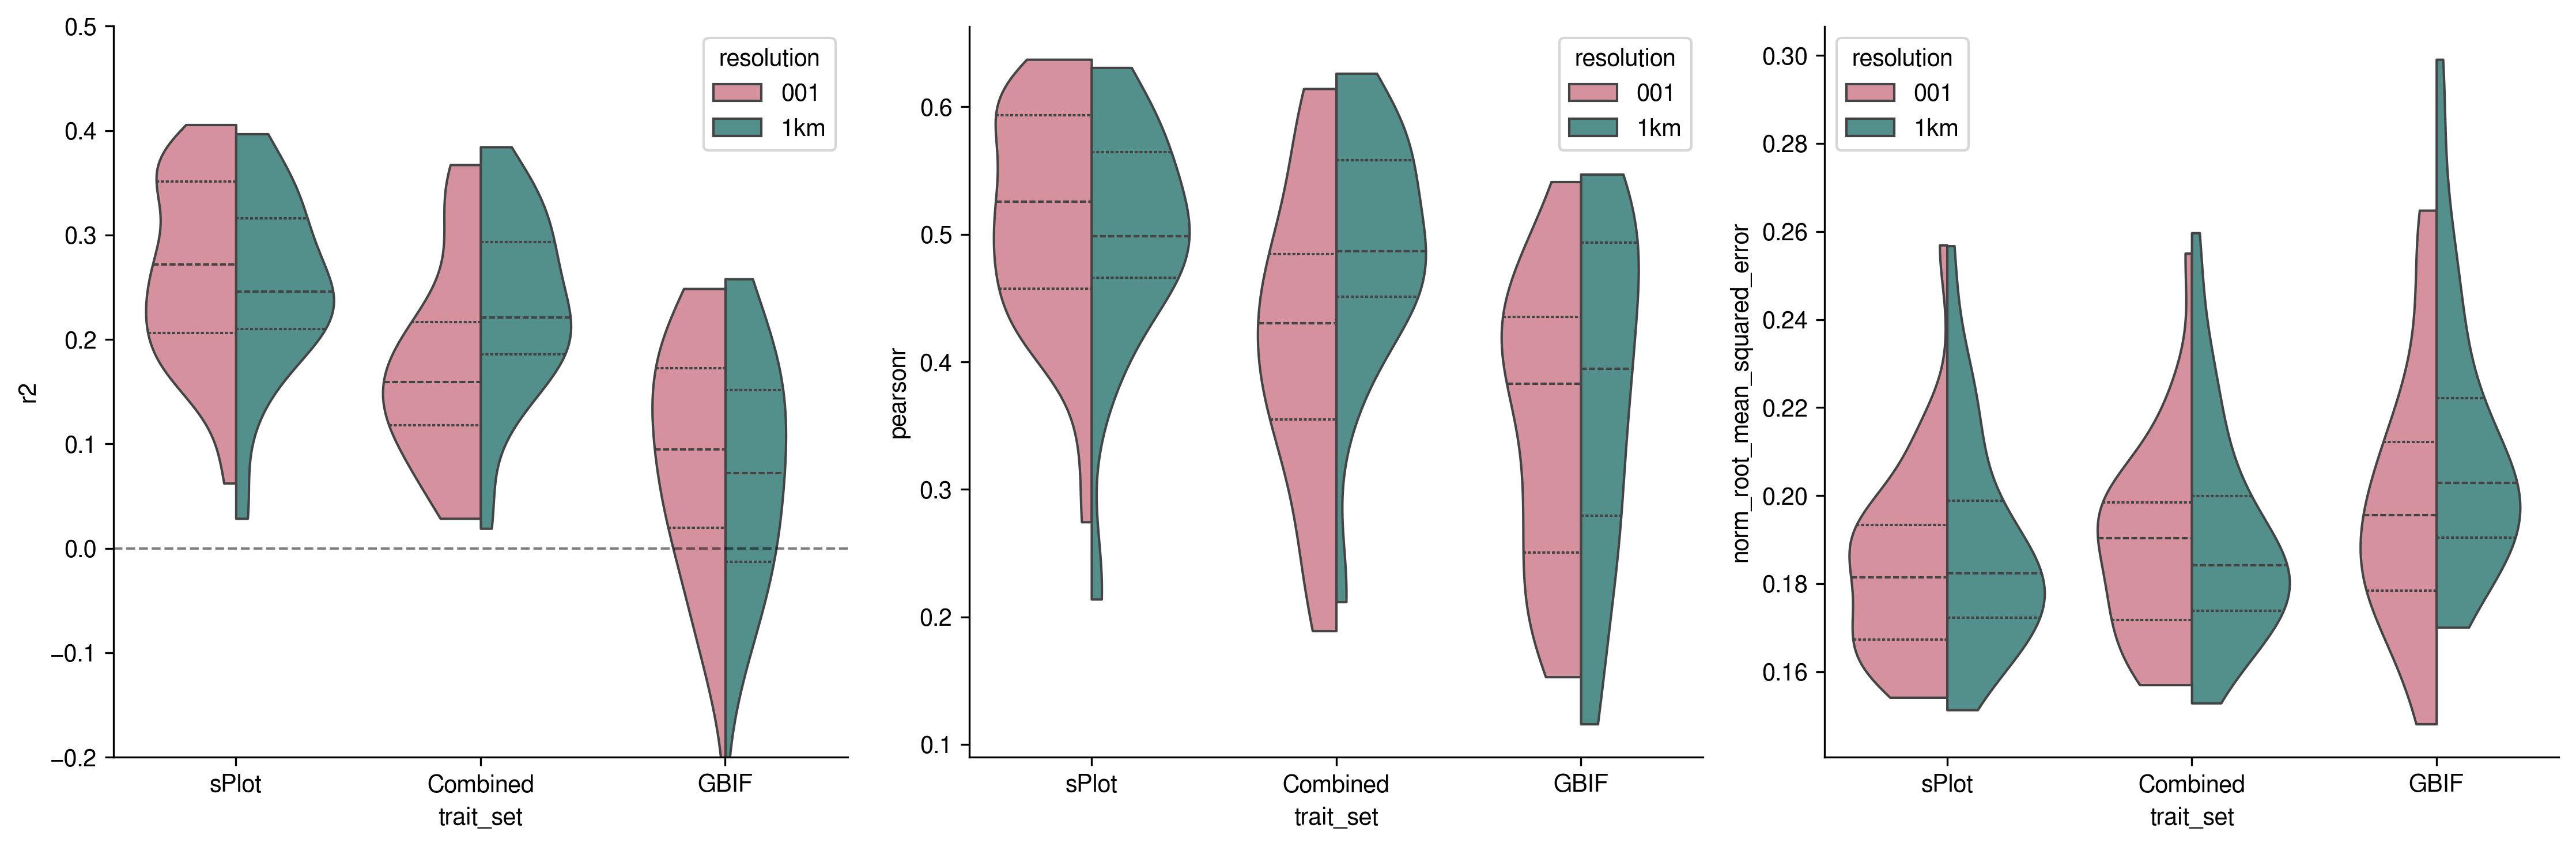

In [6]:
# Reset index to convert MultiIndex to columns
metrics = ["r2", "pearsonr", "norm_root_mean_squared_error"]
fig, axs = plt.subplots(nrows=1, ncols=3, dpi=300, figsize=(3 * 5, 5))

custom_order = ["splot", "splot_gbif", "gbif"]
custom_labels = ["sPlot", "Combined", "GBIF"]
plot_data = all_results.query(
    "(resolution == '1km' and transform == 'power') or (resolution == '001' and transform == 'none')"
)

for i, metric in enumerate(metrics):
    axes = axs.flatten()[i]
    # df_metric = df_long[["trait_id", "trait_set", "agg", metric]]
    df_metric = plot_data[["trait_id", "trait_set", metric, "resolution"]]
    df_metric = df_metric.sort_values(by="trait_set", ascending=False)

    if metric == "r2":
        # add a horizontal line at 0
        axes.axhline(0, color="black", linestyle="--", linewidth=1, alpha=0.5)
        axes.set_ylim(-0.2, 0.5)

    # Plot the mean values
    sns.violinplot(
        x="trait_set",
        y=metric,
        data=df_metric,
        hue="resolution",
        split=True,
        ax=axes,
        inner="quart",
        # color="skyblue",
        linewidth=1,
        order=custom_order,
        palette="husl",
        # dodge=True
        cut=0,
        saturation=0.5,
        # inner_kws={"linewidth": 3, "alpha": 0.2},
    )

    axes.set_xticks(axes.get_xticks(), custom_labels)
    # ax.legend(frameon=False)
    sns.despine()

# data = res_1km.query("transform == 'none'")[["trait_id", "trait_set", "r2"]]

# # Replace each trait_id with its corresponding trait name (from get_trait_name_from_id)
# # Create a dictionary to map trait_id to trait_name
# trait_id_to_name = {
#     trait_id: get_trait_name_from_id(trait_id)[0] for trait_id in data.trait_id.unique()
# }

# # Replace each trait_id with its corresponding trait name using the dictionary
# data["trait_name"] = data.trait_id.map(trait_id_to_name)

# data = data.drop(columns=["trait_id"]).sort_values(["trait_name", "r2"])
# # data = data.drop(columns=["trait_id"]).pivot_table(
#     index="trait_name", columns="trait_set", values="r2"
# )

# sorted_cols = data.apply(lambda row: row.sort_values(ascending=True).index, axis=1)
# data = data.apply(lambda row: row.sort_values(ascending=True), axis=1,)
# data.columns = sorted_cols.iloc[0]
# data = data[sorted_cols.iloc[0]]

# unique_trait_sets = data.trait_set.unique()
# # colors = sns.color_palette("husl", n_colors=len(data.columns), desat=0.5)
# colors = dict(
#     zip(
#         unique_trait_sets,
#         sns.color_palette("husl", n_colors=len(unique_trait_sets), desat=0.5),
#     )
# )
# fig, ax = plt.subplots(figsize=(10, 10))


# # for i, col in enumerate(data.columns):
# #     bottom = pd.Series(0, index=data.index)
# #     ax.bar(
# #         data.index,
# #         data[col],
# #         bottom=bottom,
# #         label=col,
# #         color=colors[i],
# #     )
# #     bottom += data[col]

# for trait_name, g in data.groupby("trait_name"):
#     # if g.r2.min() < 0:
#     #     bottom = g.r2.min()
#     #     top = 0
#     # else:
#     #     bottom = 0
#     #     top = None

#     i = 0
#     top = None
#     for _, row in g.iterrows():
#         if row.r2 < 0 and i == 0:
#             bottom = row.r2
#             top = 0
#         elif row.r2 < 0 and i > 0:
#             bottom = row.r2
#             top = 0

#         if top is None:
#             bottom = 0
#             top = row.r2

#         if i > 0:
#             top = row.r2

#         ax.bar(
#             trait_name,
#             top,
#             bottom=bottom,
#             label=trait_name if bottom == g.r2.min() else None,
#             color=colors[row.trait_set],
#         )
#         bottom = top

#         i += 1


# plt.xlabel("Trait")
# plt.ylabel("R2")
# # plt.legend(title="Trait set")
# plt.title("R2 by trait and trait set")
# plt.xticks(rotation=90)
# plt.tight_layout()

# plt.show()

plt.tight_layout()
plt.show()

Only look at untransformed performance across trait sets.


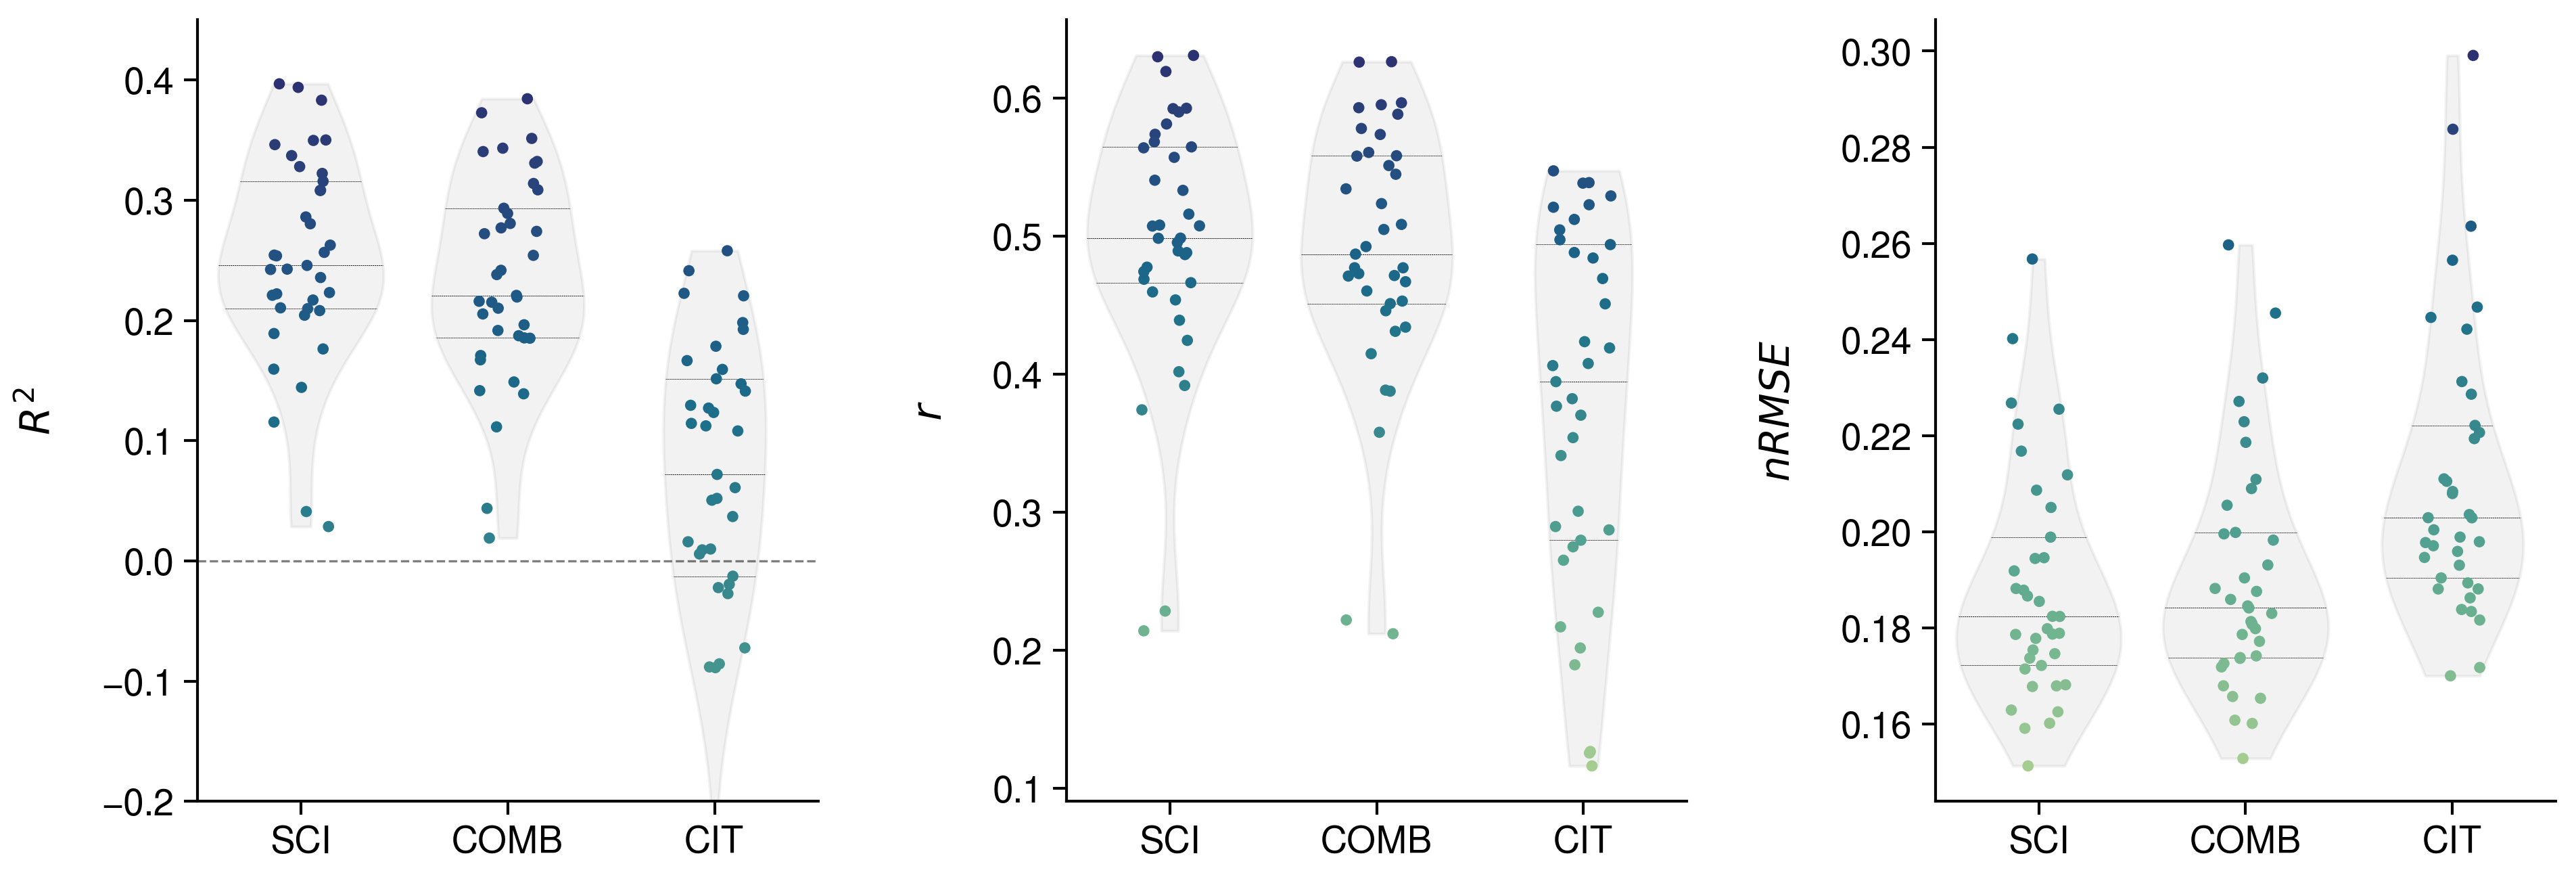

In [9]:
SAVE = True

metrics = ["r2", "pearsonr", "norm_root_mean_squared_error"]

custom_order = ["splot", "splot_gbif", "gbif"]
custom_labels = ["SCI", "COMB", "CIT"]
metric_labels = ["$R^2$", "$r$", "$nRMSE$"]

with sns.plotting_context("paper", font_scale=1.5):
    fig, axs = plt.subplots(nrows=1, ncols=3, dpi=300, figsize=(3 * 5, 5))
    for i, metric in enumerate(metrics):
        axes = axs.flatten()[i]
        # df_metric = df_long[["trait_id", "trait_set", "agg", metric]]
        df_metric = res_1km[["trait_id", "trait_set", metric, "transform"]].query(
            "transform == 'power'"
        )
        df_metric = df_metric.rename(columns={metric: metric_labels[i]})
        df_metric = df_metric.sort_values(by="trait_set", ascending=False)
        metric = metric_labels[i]
        if metric == "$R^2$":
            # add a horizontal line at 0
            axes.axhline(0, color="black", linestyle="--", linewidth=0.8, alpha=0.5)
            axes.set_ylim(-0.2, 0.45)

        # Plot the mean values
        sns.violinplot(
            x="trait_set",
            y=metric,
            data=df_metric,
            ax=axes,
            inner="quart",
            linewidth=1,
            order=custom_order,
            # palette="husl",
            cut=0,
            saturation=0.5,
            color="black",
            alpha=0.05,
            inner_kws={"linewidth": 0.2, "alpha": 1},
        )

        # Add inner points colored by their y value
        sns.stripplot(
            x="trait_set",
            y=metric,
            data=df_metric,
            ax=axes,
            palette="crest",
            hue=metric,
            order=custom_order,
            size=4,
            jitter=0.15,
            linewidth=0,
        )

        axes.set_ylabel(metric, labelpad=15)
        # ax.set_ylabel(metric_labels[idx])
        axes.set_xlabel("")
        axes.legend().remove()
        axes.set_xticks(axes.get_xticks(), custom_labels)
        # ax.legend(frameon=False)
        sns.despine()

    plt.subplots_adjust(wspace=0.4)

    if SAVE:
        plt.savefig(
            "results/figures/model-perf-trait-sets.png", dpi=300, bbox_inches="tight"
        )

## Slope, intercept, and Pearson's $r$

$R^2$ and $nRMSE$ are indeed indicators of the model performance, but $R^2$ is less relevant in our case than $r$ when it comes to the overall measure of quality when comparing our predictions to the held-out sPlot CWMs and is ultimately rather redundant. $nRMSE$ is also interesting, but again potentially redundant and perhaps not very useful given heteroscasticity in the data and the challenges of comparing "elephants to mice" (i.e. the variety in most traits across all plants is usually quite large, and so $nRMSE$ is challenging to interpret as it represents the error for some hypothetical *mean* plant).

Therefore, if the *fit* between our predicted and observed CWMs is of primary importance, then it would be of interest to look at the slopes and y-intercepts of those fits in addition to Pearson's $r$.

In [3]:
from scipy.stats import linregress

from src.utils.dataset_utils import get_all_trait_models

model_dirs = get_all_trait_models()
trait_ids = []
trait_set_ids = []
r_values = []
slopes = []
intercepts = []

for model_dir in list(model_dirs):
    trait_id = model_dir.parents[2].name
    trait_set = model_dir.name
    ovp = pd.read_parquet(model_dir / "cv_obs_vs_pred.parquet")

    obs = ovp["obs"]
    pred = ovp["pred"]
    slope, intercept, r = linregress(obs, pred)[:3]

    trait_ids.append(trait_id)
    trait_set_ids.append(trait_set)
    r_values.append(r)
    slopes.append(slope)
    intercepts.append(intercept)

fit_stats = pd.DataFrame(
    {
        "trait_id": trait_ids,
        "trait_set": trait_set_ids,
        "r": r_values,
        "slope": slopes,
        "intercept": intercepts,
    }
)

fit_stats["trait_name"] = fit_stats["trait_id"].apply(
    lambda x: get_trait_name_from_id(x)[0]
)

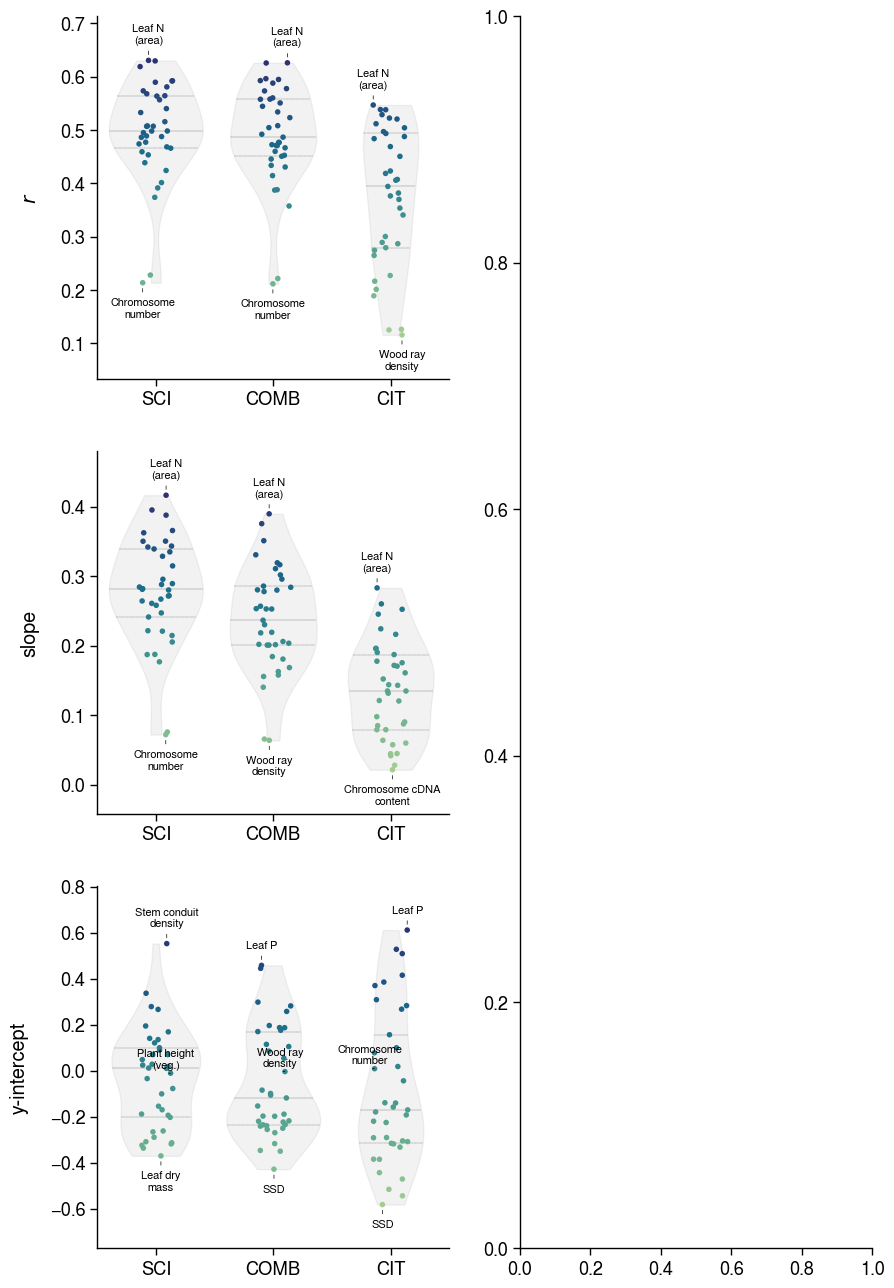

In [6]:
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

SAVE = False

metrics = ["r", "slope", "intercept"]

custom_order = ["splot", "splot_gbif", "gbif"]
custom_labels = ["SCI", "COMB", "CIT"]
metric_labels = ["$r$", "slope", "y-intercept"]

with sns.plotting_context("paper", font_scale=1.5):
    nrows = 3
    ncols = 1
    fig = plt.figure(figsize=(10, 16), dpi=100)
    gs = GridSpec(1, 2)
    nested_gs_left = GridSpecFromSubplotSpec(
        3,
        1,
        subplot_spec=gs[:, 0],
        # height_ratios=[plot, plot, 1.1],
        # width_ratios=[left_width],
        # hspace=spacer,
    )

    ax00 = plt.subplot(nested_gs_left[0])
    ax01 = plt.subplot(nested_gs_left[1])
    ax02 = plt.subplot(nested_gs_left[2])
    ax10 = plt.subplot(gs[1])

    axes = [ax00, ax01, ax02]

    for i, metric in enumerate(metrics):
        ax = axes[i]
        # df_metric = df_long[["trait_id", "trait_set", "agg", metric]]
        df_metric = fit_stats[["trait_id", "trait_set", metric, "trait_name"]]
        df_metric = df_metric.rename(columns={metric: metric_labels[i]})
        df_metric = df_metric.sort_values(by="trait_set", ascending=False)
        metric = metric_labels[i]

        # Plot the mean values
        sns.violinplot(
            x="trait_set",
            y=metric,
            data=df_metric,
            ax=ax,
            inner="quart",
            linewidth=1,
            order=custom_order,
            # palette="husl",
            cut=0,
            saturation=0.5,
            color="black",
            alpha=0.05,
            inner_kws={"linewidth": 0.2, "alpha": 1},
        )

        # Add inner points colored by their y value
        sns.stripplot(
            x="trait_set",
            y=metric,
            data=df_metric,
            ax=ax,
            palette="crest",
            hue=metric,
            order=custom_order,
            size=4,
            jitter=0.15,
            linewidth=0,
        )

        y_range = ax.get_ylim()[1] - ax.get_ylim()[0]

        ax.set_ylim(
            ax.get_ylim()[0] - (0.1 * y_range), ax.get_ylim()[1] + (0.1 * y_range)
        )

        for i, trait_set in enumerate(custom_order):
            top_trait = (
                df_metric.query(f"trait_set == '{trait_set}'")
                .sort_values(by=metric, ascending=False)
                .iloc[0]
                .trait_name
            )

            # split name to two lines if it is too long but only split on a space\
            def split_trait_name(trait_name: str) -> str:
                if len(trait_name) > 10:
                    # if >= 3 words, split on the second space, otherwise split on the first space
                    if len(trait_name.split()) >= 3:
                        split_idx = trait_name.find(" ", trait_name.find(" ") + 1)
                    else:
                        split_idx = trait_name.find(" ")
                    trait_name = (
                        trait_name[:split_idx] + "\n" + trait_name[split_idx + 1 :]
                    )
                return trait_name

            bottom_trait = (
                df_metric.query(f"trait_set == '{trait_set}'")
                .sort_values(by=metric, ascending=True)
                .iloc[0]
                .trait_name
            )

            if metric == "y-intercept":
                # Find the trait with a metric value closest to 0, aka the middle trait
                closest_to_zero_trait = (
                    df_metric.query(f"trait_set == '{trait_set}'")
                    .sort_values(by=metric, key=lambda x: abs(x))
                    .iloc[0]
                    .trait_name
                )
                

            top_trait = split_trait_name(top_trait)
            bottom_trait = split_trait_name(bottom_trait)
            if metric == "y-intercept":
                closest_to_zero_trait = split_trait_name(closest_to_zero_trait)

            top_xy = ax.collections[3 + i].get_offsets()
            top_x = top_xy[top_xy[:, 1].argsort()][-1][0]
            top_y = top_xy[top_xy[:, 1].argsort()][-1][1] + (0.01 * y_range)

            bottom_xy = ax.collections[3 + i].get_offsets()
            bottom_x = bottom_xy[bottom_xy[:, 1].argsort()][0][0]
            bottom_y = bottom_xy[bottom_xy[:, 1].argsort()][0][1] - (0.01 * y_range)

            if metric == "y-intercept":
                closest_to_zero_xy = ax.collections[3 + i].get_offsets()
                abs_diff = np.abs(closest_to_zero_xy[:, 1])
                idx = np.argmin(abs_diff)
                closest_to_zero_x = closest_to_zero_xy[idx, 0]
                closest_to_zero_y = closest_to_zero_xy[idx, 1]

            # Draw a small line diagonally at a random angle upwards
            # angle = np.random.uniform(60, 120)  # Random angle between 20 and 70 degrees
            top_angle = 90
            bottom_angle = 270
            closest_to_zero_angle = 180
            length = 0.03 * y_range  # Length of the line
            dx_top = length * np.cos(np.radians(top_angle))
            dy_top = length * np.sin(np.radians(top_angle))
            dx_bottom = length * np.cos(np.radians(bottom_angle))
            dy_bottom = length * np.sin(np.radians(bottom_angle))
            if metric == "y-intercept":
                dx_closest_to_zero = length * np.cos(np.radians(closest_to_zero_angle))
                dy_closest_to_zero = length * np.sin(np.radians(closest_to_zero_angle))

                ax.annotate(
                    "",
                    xy=(closest_to_zero_x, closest_to_zero_y),
                    xytext=(closest_to_zero_x + dx_closest_to_zero, closest_to_zero_y + dy_closest_to_zero),
                    arrowprops=dict(arrowstyle="-", color="black", lw=0.5),
                )

                ax.annotate(
                    closest_to_zero_trait,
                    (closest_to_zero_x + dx_closest_to_zero, closest_to_zero_y + dy_closest_to_zero),
                    textcoords="offset points",
                    xytext=(0, 2),
                    ha="center",
                    va="bottom",
                    fontsize=8,
                    color="black",
                    annotation_clip=False,
                )

            ### Top annotation
            ax.annotate(
                "",
                xy=(top_x, top_y),
                xytext=(top_x + dx_top, top_y + dy_top),
                arrowprops=dict(arrowstyle="-", color="black", lw=0.5),
            )

            ax.annotate(
                top_trait,
                (top_x + dx_top, top_y + dy_top),
                textcoords="offset points",
                xytext=(0, 2),
                ha="center",
                va="bottom",
                fontsize=8,
                color="black",
                annotation_clip=False,
            )

            ### Bottom annotation
            ax.annotate(
                "",
                xy=(bottom_x, bottom_y),
                xytext=(bottom_x + dx_bottom, bottom_y + dy_bottom),
                arrowprops=dict(arrowstyle="-", color="black", lw=0.5),
            )

            ax.annotate(
                bottom_trait,
                (bottom_x + dx_bottom, bottom_y + dy_bottom),
                textcoords="offset points",
                xytext=(0, -2),
                ha="center",
                va="top",
                fontsize=8,
                color="black",
                annotation_clip=False,
            )

        ax.set_ylabel(metric, labelpad=15)
        # ax.set_ylabel(metric_labels[idx])
        ax.set_xlabel("")
        ax.legend().remove()
        ax.set_xticks(ax.get_xticks(), custom_labels)
        # ax.legend(frameon=False)
        sns.despine()

    # ax10 = plot_splot_correlations([ax10], all_results, "Shrub_Tree_Grass", ["COMB"])

    #     def plot_splot_correlations(
    #     axes: list[Axes], df: pd.DataFrame, pft: str, trait_set_ids: list[str], out_path: Path | None = None
    # ):
    # plt.subplots_adjust(wspace=0.4)

    if SAVE:
        plt.savefig(
            "results/figures/model-perf-trait-sets.png", dpi=300, bbox_inches="tight"
        )

In [ ]:
import warnings

import matplotlib.gridspec as gridspec

warnings.filterwarnings("ignore")

traits = [d for d in Path("results/Shrub_Tree_Grass/1km").glob("*") if d.is_dir()]
ts = ["splot", "splot_gbif", "gbif"]
m = len(traits)
n = len(ts)
# Create the main GridSpec
fig = plt.figure(figsize=(n * 6, m * 4), dpi=200)
outer_grid = gridspec.GridSpec(m, n, wspace=0.2, hspace=0.7)

trait_set_cmap = {"splot": "red", "splot_gbif": "green", "gbif": "blue"}

trait_set_names = {"splot": "sPlot", "splot_gbif": "Combined", "gbif": "GBIF"}

with sns.plotting_context("paper", font_scale=1), sns.axes_style("ticks"):
    for i, trait_dir in enumerate(traits):
        trait_id = trait_dir.name
        for j, trait_set_id in enumerate(ts):
            # Create a nested GridSpec for each cell in the main grid
            inner_grid = gridspec.GridSpecFromSubplotSpec(
                1, 2, subplot_spec=outer_grid[i, j], hspace=0.1
            )

            results_dir = get_latest_run(trait_dir / trait_set_id)

            desired_stats = ["r2", "pearsonr", "norm_root_mean_squared_error"]
            col_map = {
                "r2": "R²",
                "pearsonr": "$r$",
                "norm_root_mean_squared_error": "nRMSE",
            }

            stats = (
                res_1km.query(
                    f"trait_id == '{trait_id}' and trait_set == '{trait_set_id}' and transform == 'none'"
                )[desired_stats]
                .rename(columns=col_map)
                .to_dict(orient="records")[0]
            )
            stats_ln = (
                res_1km.query(
                    f"trait_id == '{trait_id}' and trait_set == '{trait_set_id}' and transform == 'log'"
                )[desired_stats]
                .rename(columns=col_map)
                .to_dict(orient="records")[0]
            )

            obs_vs_pred = pd.read_parquet(
                results_dir / "cv_obs_vs_pred.parquet"
            ).sample(frac=0.1)


In [ ]:
median_values = (
    res_1km.query("transform == 'none'")
    .groupby("trait_set")[metrics]
    .agg(["mean", "median", "std", "max", "min"])
)
median_values

r2                                         pearsonr_wt  \
                mean    median       std       max       min        mean   
trait_set                                                                  
gbif        0.078038  0.094911  0.137299  0.248642 -0.446095    0.355789   
splot       0.264971  0.272000  0.088836  0.405653  0.062355    0.514924   
splot_gbif  0.176985  0.159426  0.097549  0.367329  0.028602    0.422274   

                                                    \
              median       std       max       min   
trait_set                                            
gbif        0.394558  0.116522  0.552563  0.154413   
splot       0.519534  0.087247  0.632900  0.277659   
splot_gbif  0.440881  0.122354  0.622571  0.192602   

           norm_root_mean_squared_error                                \
                                   mean    median       std       max   
trait_set                                                               
gbif                           0.199164  0.195511  0.030379  0.264801   
splot                          0.183493  0.181456  0.021649  0.256902   
splot_gbif                     0.187978  0.190321  0.021990  0.255043   

                      
                 min  
trait_set             
gbif        0.148099  
splot       0.154134  
splot_gbif  0.156989

### Visualize Pearson's $r$ across trait sets for all traits at 1 km resolution


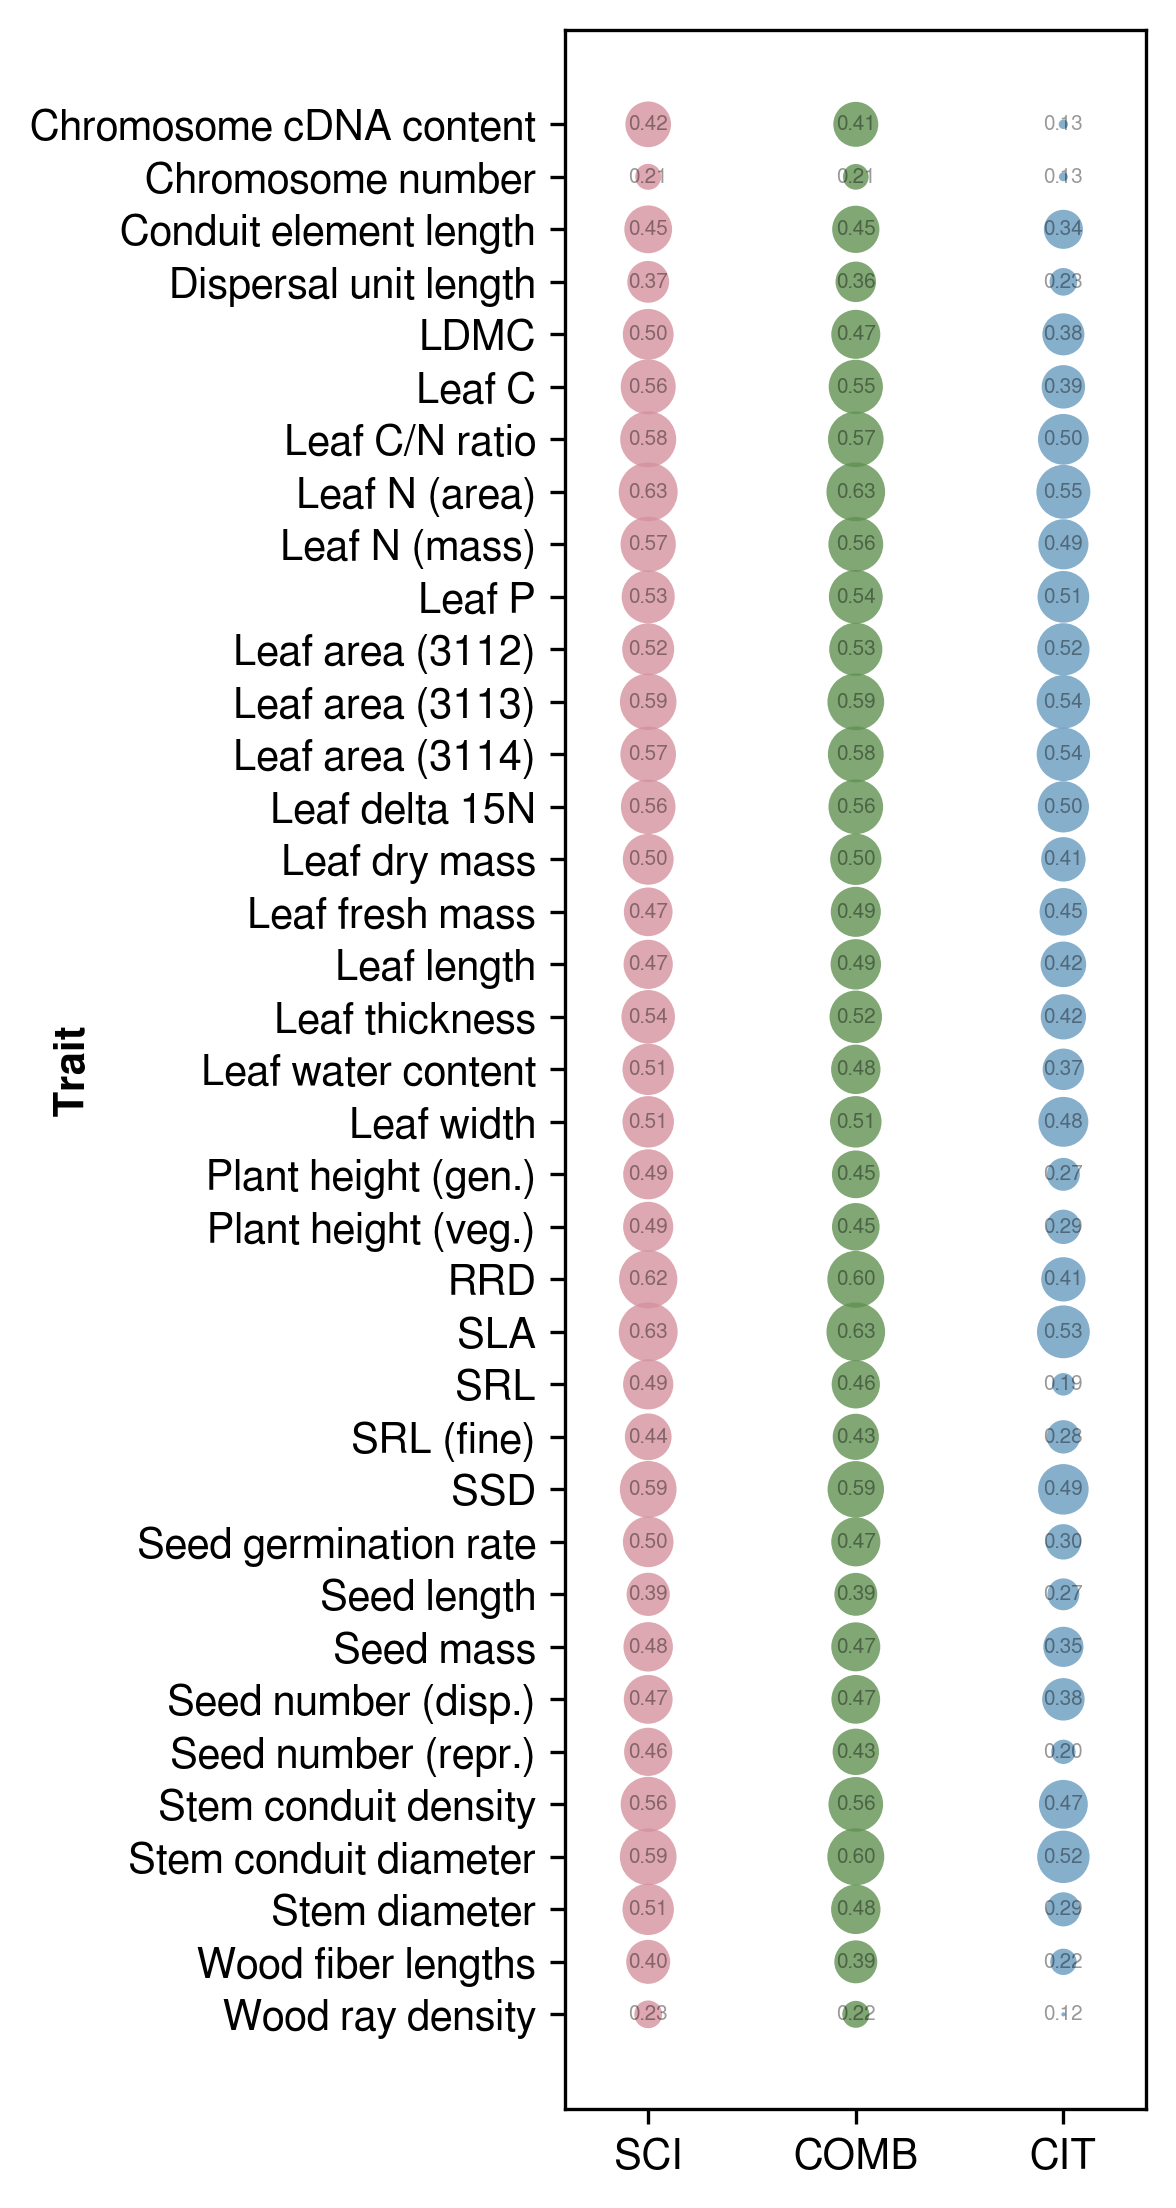

In [13]:
SAVE = True

# Filter the data for transform == 'none'
heatmap_data = res_1km.query("transform == 'power'").copy()
heatmap_data.trait_id = heatmap_data.trait_id.apply(get_trait_name_from_id)
heatmap_data.trait_id = heatmap_data.trait_id.apply(lambda x: x[0])
trait_set_labels = ["SCI", "COMB", "CIT"]
trait_set_vals = ["splot", "splot_gbif", "gbif"]
heatmap_data["trait_set"] = heatmap_data["trait_set"].map(
    dict(zip(trait_set_vals, trait_set_labels))
)

# Pivot the data to get the desired format for the heatmap
heatmap_data_pivot = heatmap_data.pivot(
    index="trait_id", columns="trait_set", values="pearsonr"
)

# Reorder the columns
heatmap_data_pivot = heatmap_data_pivot[trait_set_labels]

# Create a scatter plot with circles representing the magnitude of pearsonr values
plt.figure(figsize=(2.5, 9), dpi=300)
palette = sns.color_palette("husl", n_colors=len(trait_set_labels), desat=0.5)
scatter_data = heatmap_data_pivot.reset_index().melt(
    id_vars="trait_id", var_name="Trait Set", value_name="pearsonr"
)
sns.scatterplot(
    data=scatter_data,
    x="Trait Set",
    y="trait_id",
    hue="Trait Set",
    palette=palette,
    size="pearsonr",
    sizes=(1, 200),
    alpha=0.8,
    legend=False,
    linewidth=0,
)

# Add r value inside each circle
for _, best_trait in scatter_data.iterrows():
    plt.text(
        best_trait["Trait Set"],
        best_trait["trait_id"],
        f"{best_trait['pearsonr']:.2f}",
        ha="center",
        va="center",
        fontsize=5,
        color="black",
        alpha=0.4,
    )

# Add padding between the left vertical border and the first x tick and the right vertical border and the last x tick
plt.gca().margins(x=0.2)
plt.xlabel("")
plt.ylabel("Trait", labelpad=-15, fontweight="bold")
# plt.title("Pearson's r values represented by circle sizes")

if SAVE:
    plt.savefig("results/figures/pearsonr-circles.png", dpi=300, bbox_inches="tight")

plt.show()

Let's look at just the sPlot+GBIF Pearson's $r$ top performers.


In [16]:
pd.set_option("display.max_rows", None)
res_1km.query("transform == 'power' and trait_set == 'splot_gbif'")[
    ["trait_name", "pearsonr", "trait_set_id"]
].sort_values("pearsonr", ascending=False)

trait_name  pearsonr trait_set_id
250            Leaf N (area)  0.626219         COMB
298                      SLA  0.625903         COMB
370    Stem conduit diameter  0.596451         COMB
196                      RRD  0.595019         COMB
208         Leaf area (3113)  0.592884         COMB
364                      SSD  0.588171         COMB
280         Leaf area (3114)  0.577834         COMB
244           Leaf C/N ratio  0.573486         COMB
376            Leaf N (mass)  0.560474         COMB
190     Stem conduit density  0.558094         COMB
214           Leaf delta 15N  0.557829         COMB
262                   Leaf C  0.550988         COMB
292                   Leaf P  0.544675         COMB
172         Leaf area (3112)  0.534099         COMB
202           Leaf thickness  0.523411         COMB
178               Leaf width  0.508332         COMB
382            Leaf dry mass  0.504669         COMB
346              Leaf length  0.492286         COMB
322          Leaf fresh mass  0.486822         COMB
274            Stem diameter  0.476929         COMB
220       Leaf water content  0.476901         COMB
334    Seed germination rate  0.472720         COMB
232                     LDMC  0.471311         COMB
304                Seed mass  0.470911         COMB
358      Seed number (disp.)  0.466827         COMB
286                      SRL  0.460120         COMB
256      Plant height (gen.)  0.452791         COMB
238      Plant height (veg.)  0.450947         COMB
184   Conduit element length  0.445795         COMB
166      Seed number (repr.)  0.433921         COMB
226               SRL (fine)  0.430882         COMB
328  Chromosome cDNA content  0.414673         COMB
316       Wood fiber lengths  0.388279         COMB
340              Seed length  0.387539         COMB
352    Dispersal unit length  0.357741         COMB
310         Wood ray density  0.221757         COMB
268        Chromosome number  0.211792         COMB

## Multi-resolution Pearson's $r$


In [ ]:
def convert_resolution(res_str):
    try:
        return float(res_str) / 100 if len(res_str) > 1 else float(res_str)
    except ValueError:
        raise ValueError(f"Invalid resolution string: {res_str}")


# Example usage
print(convert_resolution("001"))  # Output: 0.01
print(convert_resolution("5"))  # Output: 5.0

0.01
5.0


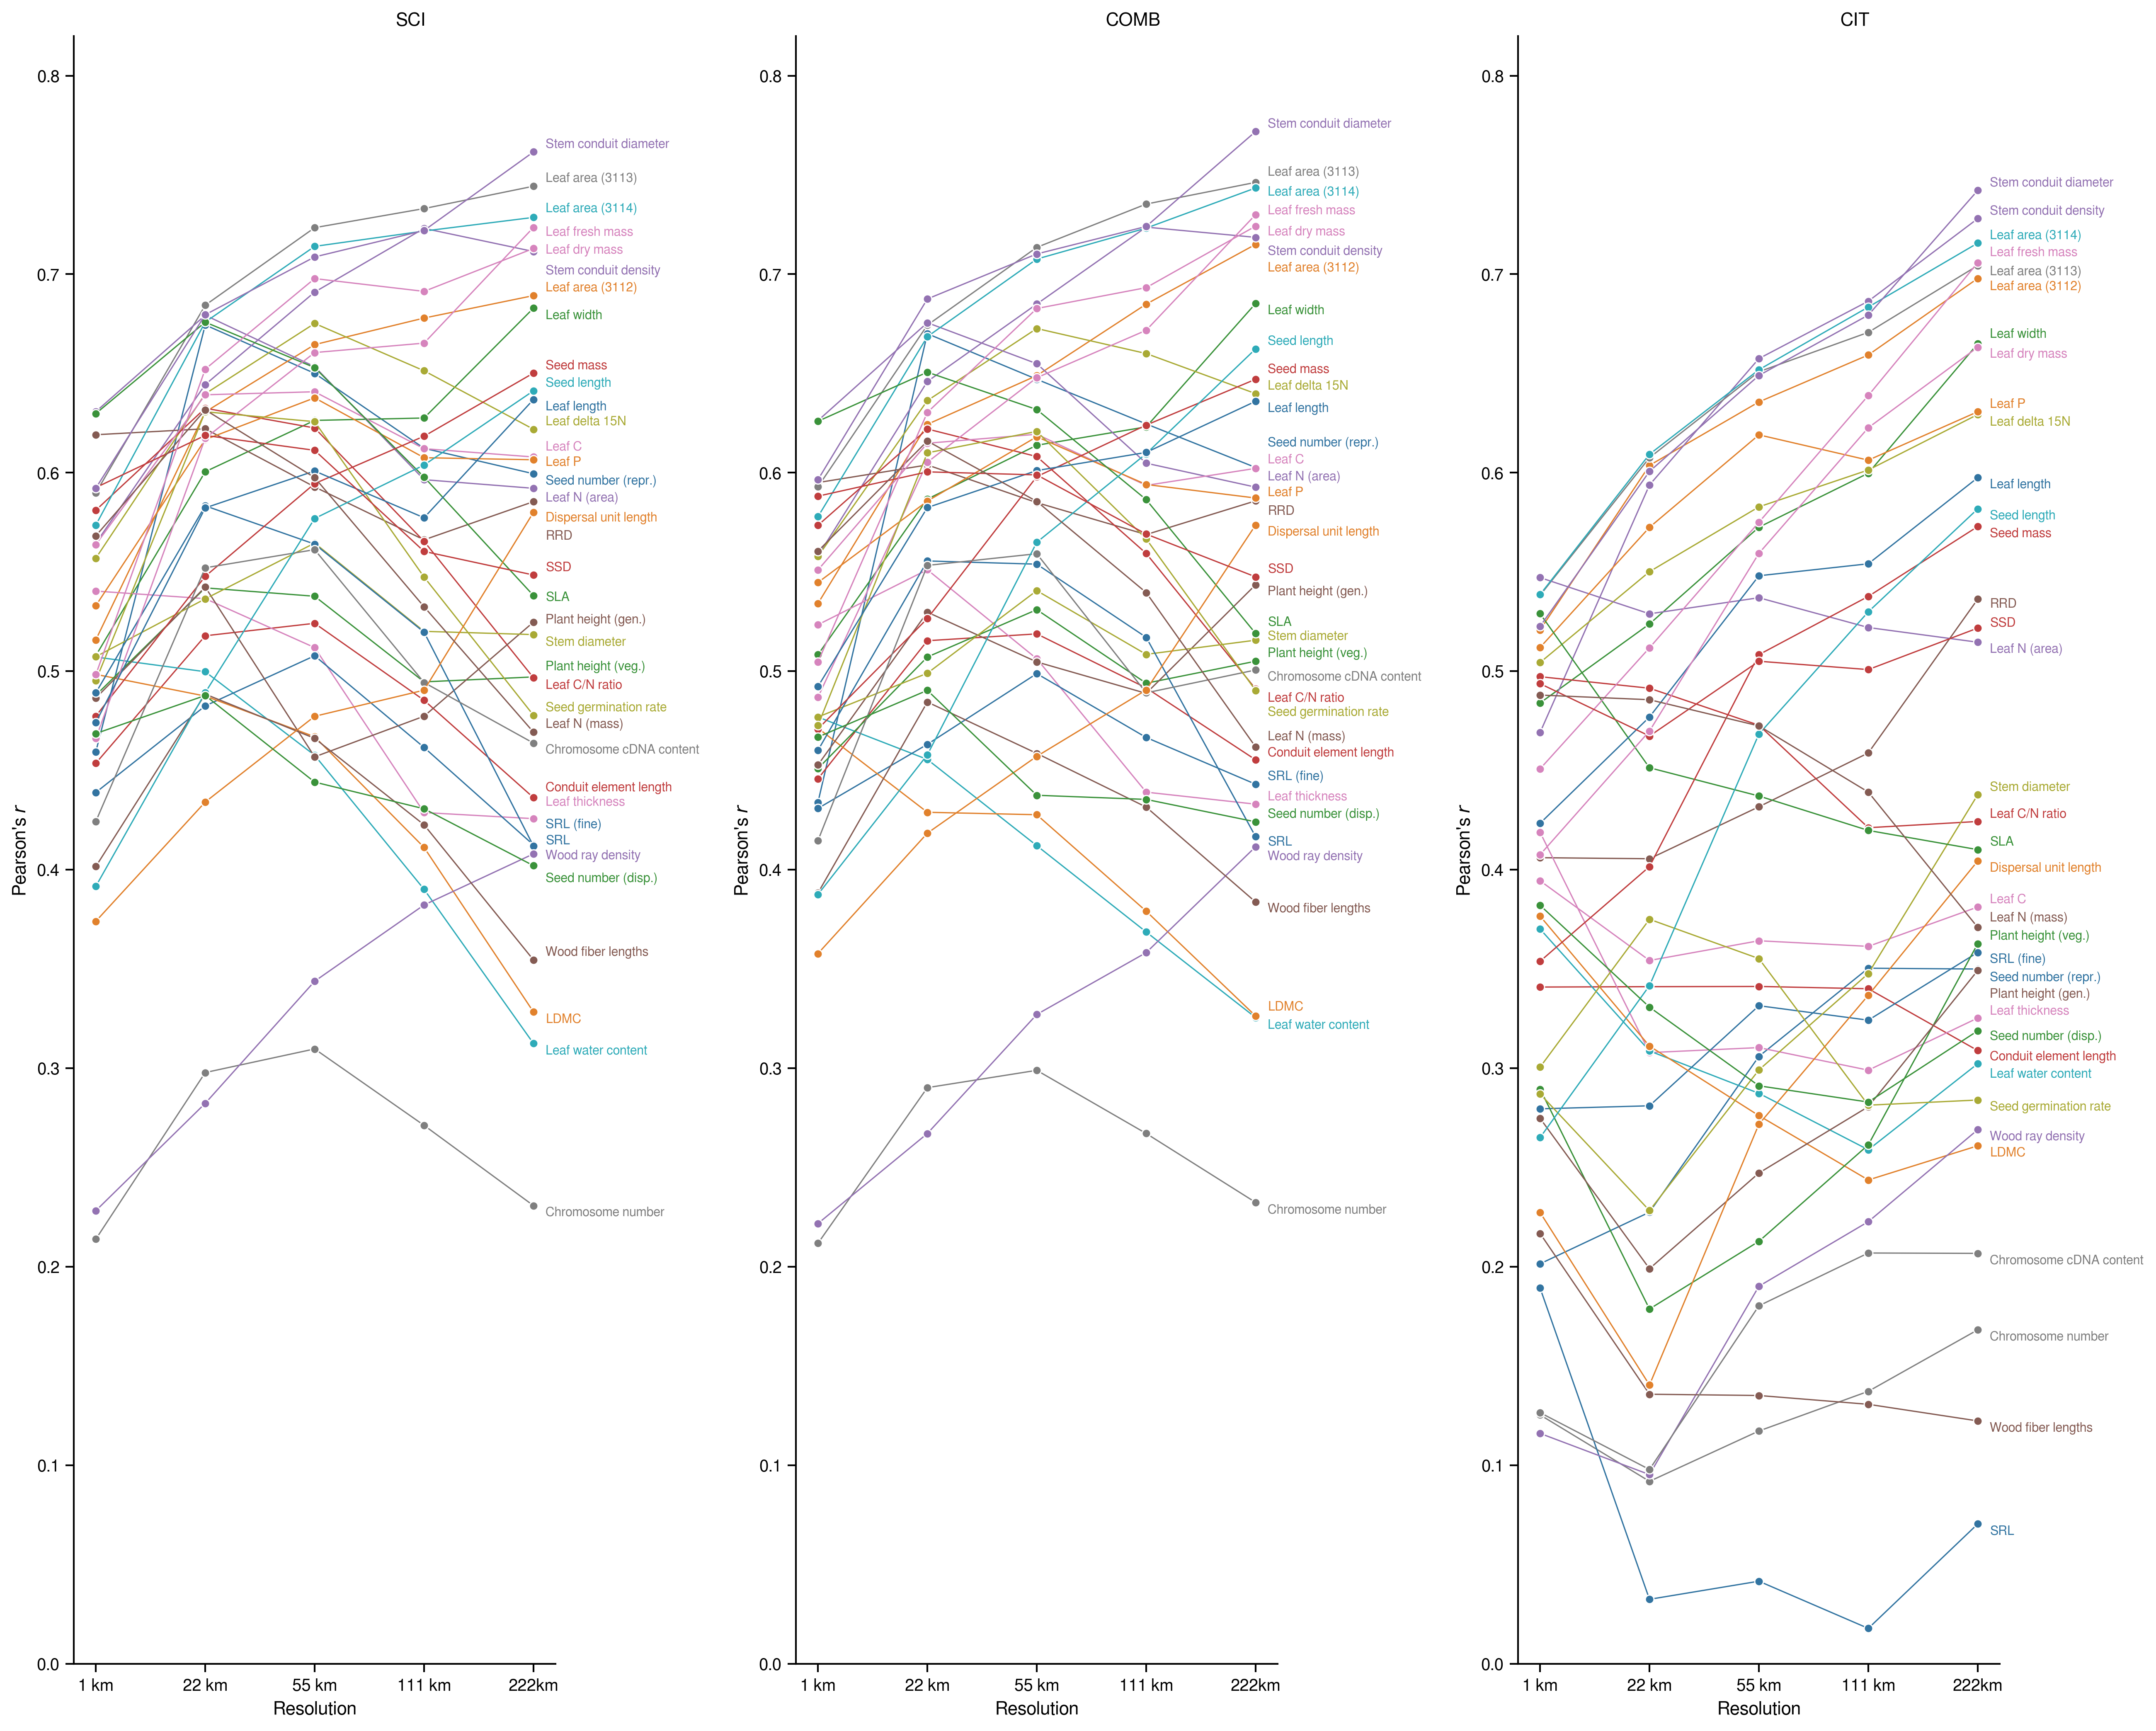

In [25]:
with sns.plotting_context("paper", font_scale=1.1):
    plot_splot_correlations(
        df=all_results,
        pft="Shrub_Tree_Grass",
        trait_set_ids=["SCI", "COMB", "CIT"],
        out_path=Path("results/figures/multires_r_all_trait_sets.png"),
    )

### Only show GBIF+sPlot Pearson's $r$ across resolutions


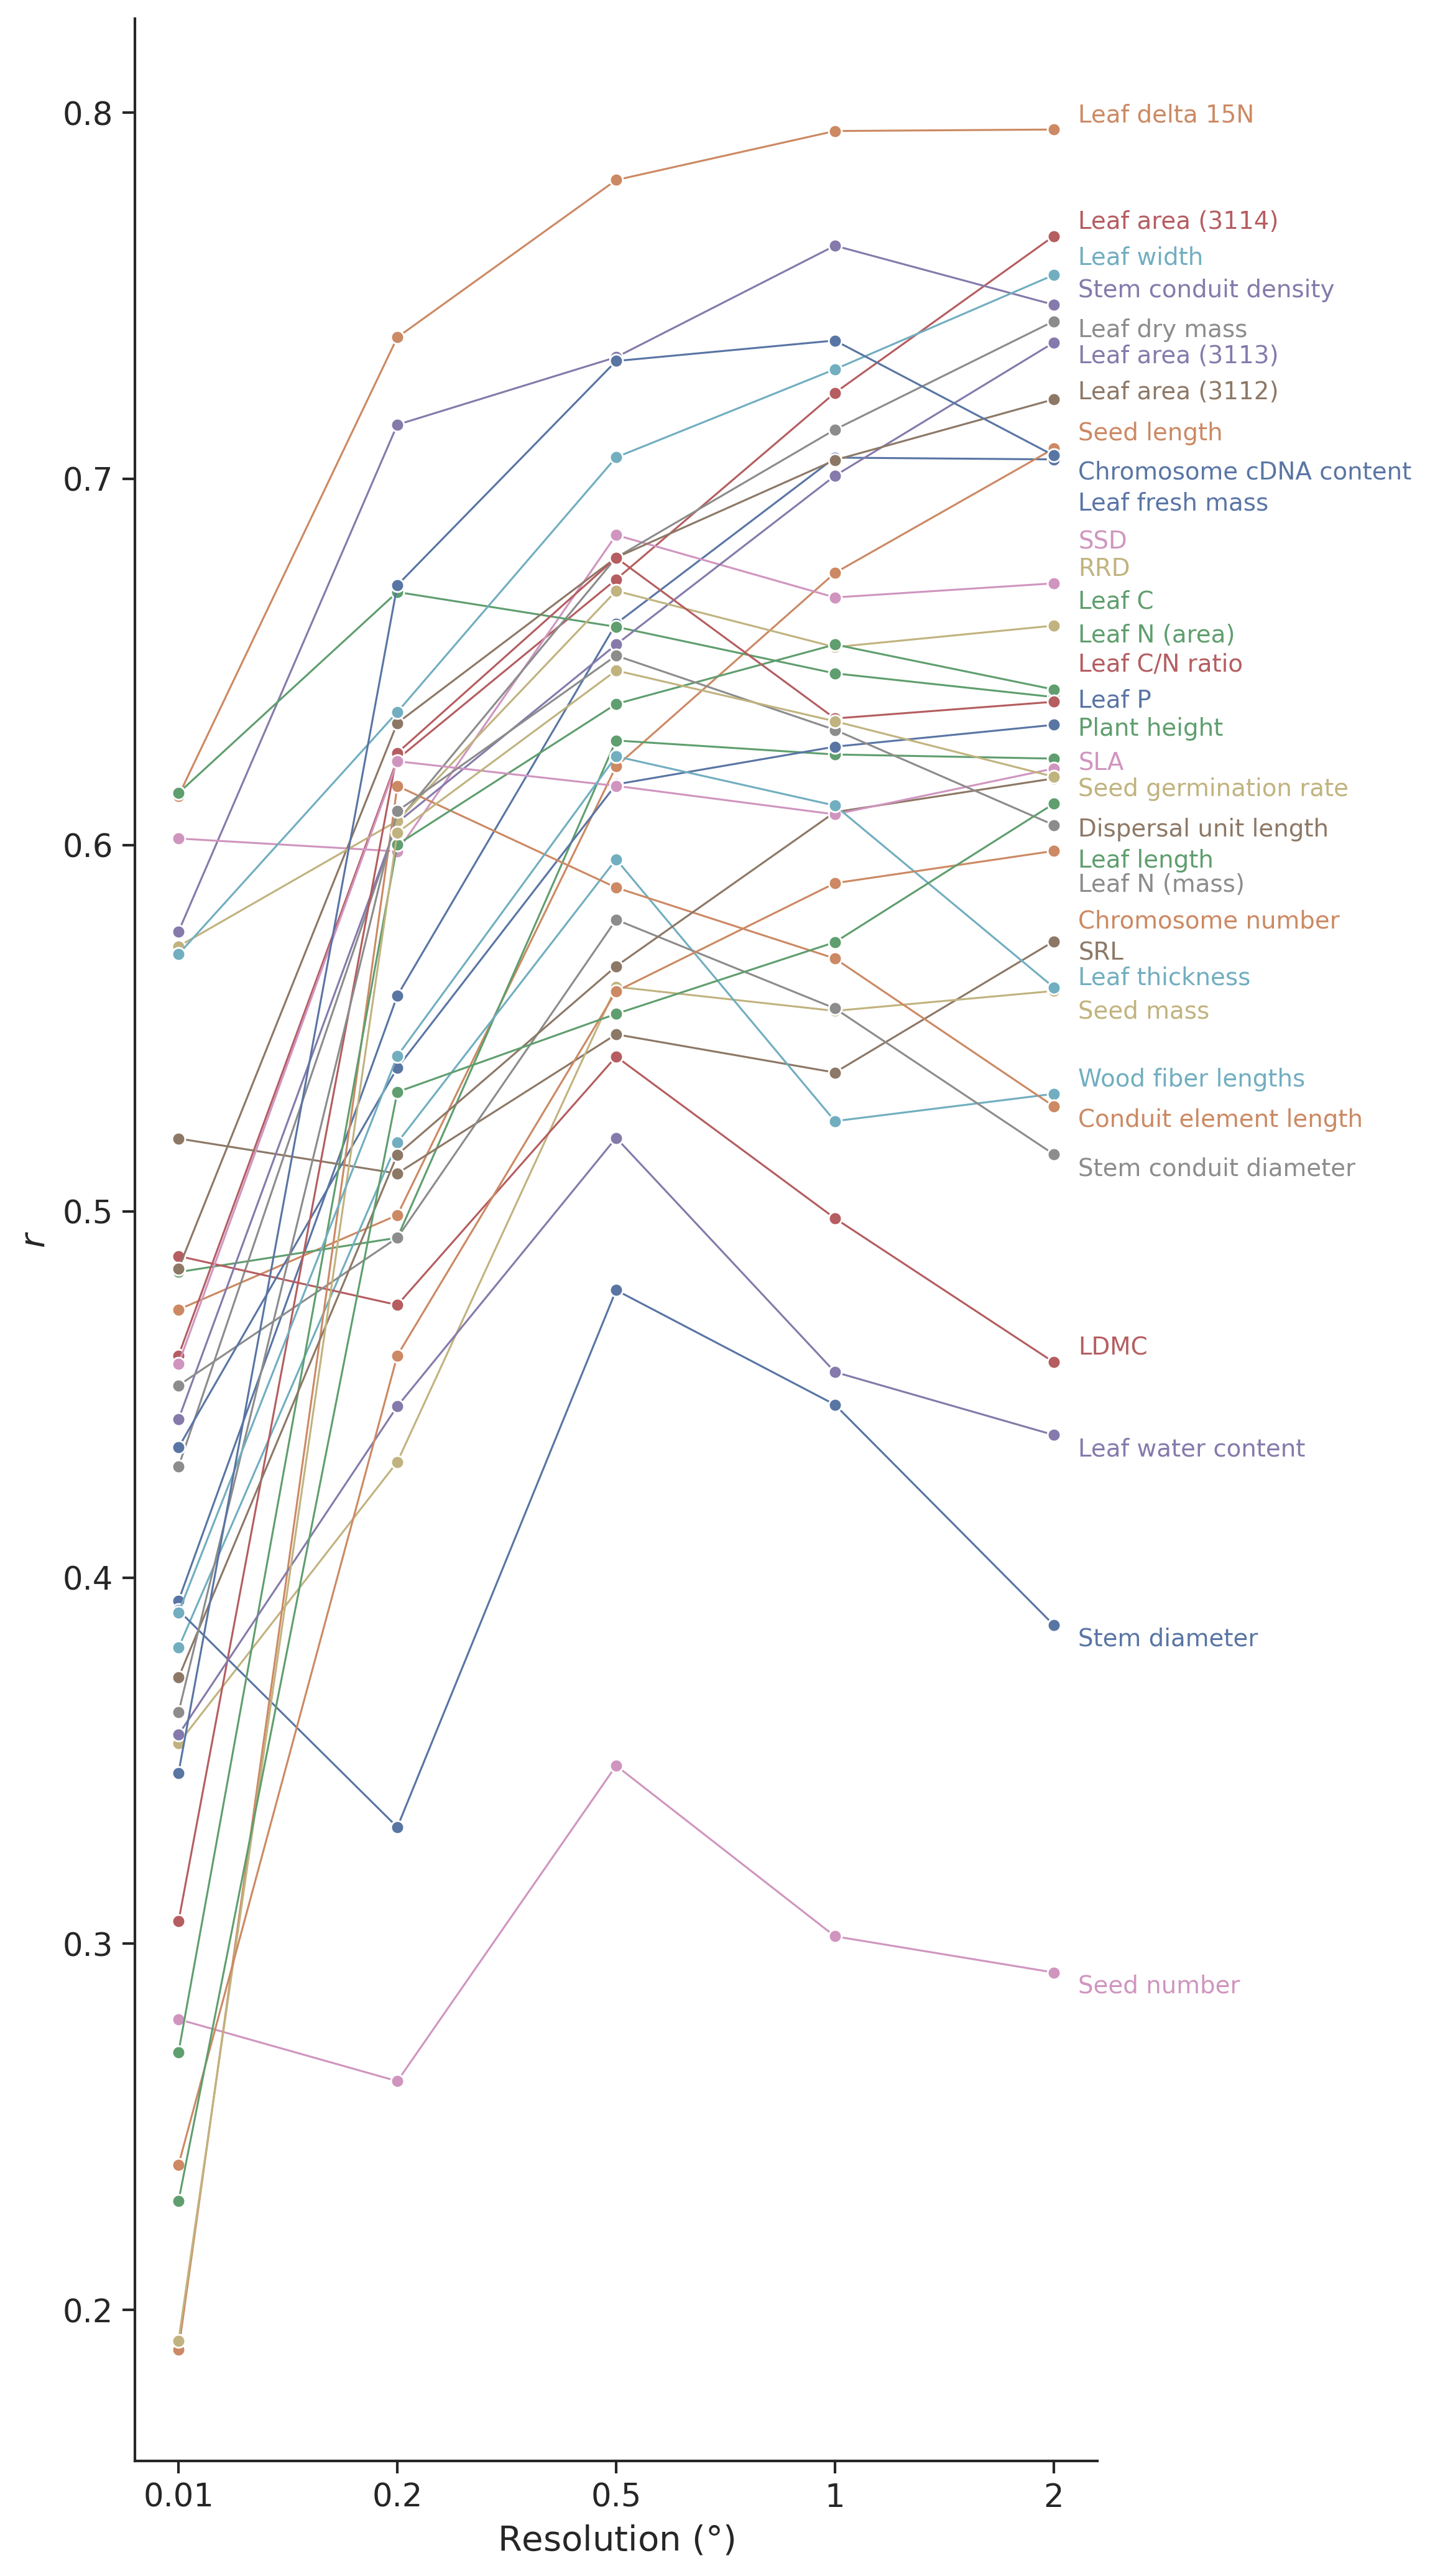

In [ ]:
out_path = Path("results/figures/pearsonr_multires_COMB.png")
with sns.plotting_context("paper", font_scale=1.4):
    plot_splot_correlations(all_results, "Shrub_Tree_Grass", ["COMB"], out_path)

### Show trait changes with decreasing resolution.


In [12]:
data = all_results.query(
    "transform == 'power' and trait_set == 'splot_gbif' and resolution.str.contains('km')"
)[["trait_name", "pearsonr", "resolution"]].pivot(
    index="trait_name", columns="resolution", values="pearsonr"
)[["1km", "22km", "55km", "111km", "222km"]]


def color_cells(val, prev_val):
    if val > prev_val:
        color = "background-color: green; color: white"
    elif val < prev_val:
        color = "background-color: red; color: white"
    else:
        color = ""
    return color


data_styled = data.style.apply(
    lambda x: [
        color_cells(x.iloc[i], x.iloc[i - 1]) if i > 0 else "" for i in range(len(x))
    ],
    axis=1,
)
print(
    "Trait performance compared to the next highest resolution\n(green = increase from previous resolution, red = decrease):"
)
data_styled

Trait performance compared to the next highest resolution
(green = increase from previous resolution, red = decrease):


Max $r$ across all resolutions.


In [59]:
data.style.highlight_max(axis=0)